# Titanic: Machine Learning from Disaster

## Introduction

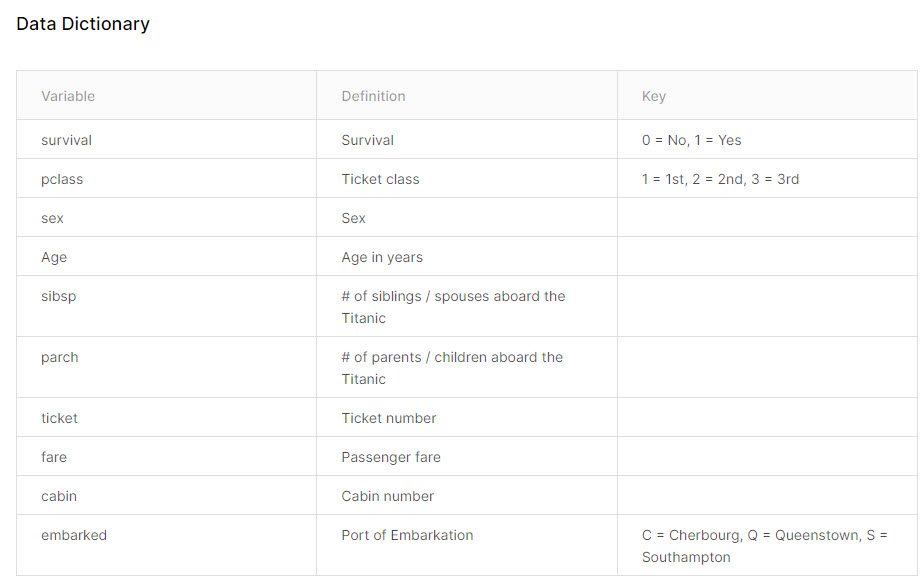

In [ ]:
## Importing the required libraries
###################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import plotly 
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [ ]:
## Read and Examine the Dataset
###################################

df = pd.read_csv("../input/titanic/train.csv")
df.head()

In [ ]:
df.columns

In [ ]:
df.columns = [col.upper() for col in df.columns]

In [ ]:
print(df.columns.values)

In [ ]:
df.shape

In [ ]:
## Getting information about the missing values and data types in the dateset
###############################################################################

df.info()

In [ ]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap="viridis")

In [ ]:
df.sample(10)

## 1.Step Exploratory Data Analysis (EDA)

In [ ]:
#############################################
## Arrange the columns in the dataset according to the information given in the dictionary of the dataset
#############################################

    
# Cabin bool
df["NEW_CABIN_BOOL"] = df["CABIN"].notnull().astype('int')
# Name count
df["NEW_NAME_COUNT"] = df["NAME"].str.len()
# name word count
df["NEW_NAME_WORD_COUNT"] = df["NAME"].apply(lambda x: len(str(x).split(" ")))
# name dr with .
df["NEW_NAME_DR"] = df["NAME"].apply(lambda x: len([x for x in x.split() if x.startswith("Dr.")]))
# name title
df['NEW_TITLE'] = df.NAME.str.extract(' ([A-Za-z]+)\.', expand=False)
# family size
df["NEW_FAMILY_SIZE"] = df["SIBSP"] + df["PARCH"] + 1
# age_pclass
df["NEW_AGE_PCLASS"] = df["AGE"] * df["PCLASS"]
# is alone
df.loc[((df['SIBSP'] + df['PARCH']) > 0), "NEW_IS_ALONE"] = "NO"
df.loc[((df['SIBSP'] + df['PARCH']) == 0), "NEW_IS_ALONE"] = "YES"
# age level
df.loc[(df['AGE'] < 18), 'NEW_AGE_CAT'] = 'young'
df.loc[(df['AGE'] >= 18) & (df['AGE'] < 56), 'NEW_AGE_CAT'] = 'mature'
df.loc[(df['AGE'] >= 56), 'NEW_AGE_CAT'] = 'senior'
# sex x age
df.loc[(df['SEX'] == 'male') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngmale'
df.loc[(df['SEX'] == 'male') & ((df['AGE'] > 21) & (df['AGE']) <= 50), 'NEW_SEX_CAT'] = 'maturemale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] > 50), 'NEW_SEX_CAT'] = 'seniormale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngfemale'
df.loc[(df['SEX'] == 'female') & ((df['AGE'] > 21) & (df['AGE']) <= 50), 'NEW_SEX_CAT'] = 'maturefemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] > 50), 'NEW_SEX_CAT'] = 'seniorfemale'


In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
def overview_dataset(dataframe, cat_th=10, car_th=20):
    
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

In [ ]:
cat_cols, num_cols, cat_but_car = overview_dataset(df)
num_cols = [col for col in num_cols if "PASSENGERID" not in col]

In [ ]:
sns.boxplot(x='EMBARKED', y='FARE', data=df)
plt.title("Fare distribution as function of Embarked Port")
plt.show()

In [ ]:
def outlier_winsorize(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    upper = Q3 + 1.5 * IQR
    lower = Q1 - 1.5 * IQR
    df.loc[(df[col] < lower), col] = lower
    df.loc[(df[col] > upper), col] = upper
   

In [ ]:
num_cols

In [ ]:
for col in num_cols:
    outlier_winsorize(df,col)

In [ ]:
sns.boxplot(y='FARE', data=df)
plt.title("Age distribution as function of Embarked Port")
plt.show()

In [ ]:
## Drop the missing values in the "CABIN" column

df.drop("CABIN", inplace=True, axis=1)

In [ ]:
remove_cols = ["TICKET", "NAME"]
df.drop(remove_cols, inplace=True, axis=1)

##### As you can see, there are some variables in the NEW_TITLE colon. 
These values were grouped in their own, and their medians were taken, and the missing values were filled with these values.

In [ ]:
df["NEW_TITLE"].value_counts()

In [ ]:

df["AGE"] = df["AGE"].fillna(df.groupby("NEW_TITLE")["AGE"].transform("median"))


df["NEW_AGE_PCLASS"] = df["AGE"] * df["PCLASS"]
df.loc[(df['AGE'] < 18), 'NEW_AGE_CAT'] = 'young'
df.loc[(df['AGE'] >= 18) & (df['AGE'] < 56), 'NEW_AGE_CAT'] = 'mature'
df.loc[(df['AGE'] >= 56), 'NEW_AGE_CAT'] = 'senior'

df.loc[(df['SEX'] == 'male') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngmale'
df.loc[(df['SEX'] == 'male') & ((df['AGE'] > 21) & (df['AGE']) <= 50), 'NEW_SEX_CAT'] = 'maturemale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] > 50), 'NEW_SEX_CAT'] = 'seniormale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngfemale'
df.loc[(df['SEX'] == 'female') & ((df['AGE'] > 21) & (df['AGE']) <= 50), 'NEW_SEX_CAT'] = 'maturefemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] > 50), 'NEW_SEX_CAT'] = 'seniorfemale'

df = df.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= 10) else x, axis=0)

In [ ]:
pd.isnull(df).sum()

In [ ]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap="viridis")

In [ ]:
def label_encoder(df, binary_col):
    labelencoder = LabelEncoder()
    df[binary_col] = labelencoder.fit_transform(df[binary_col])
    return df

In [ ]:
binary_cols = [col for col in df.columns if df[col].dtype not in [int, float] and df[col].nunique() == 2]

for col in binary_cols:
    df = label_encoder(df, col)

In [ ]:
def rare_encoder(df, rare_perc):
    temp_df = df.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

#### Rare Variable Analysis. 
In the "NEW_TITLE" column, there are many values such as dr., col, capt, which are rarely mentioned. We will rare encode this variable.

In [ ]:
df = rare_encoder(df, 0.01)

In [ ]:
def one_hot_encoder(df, categorical_cols, drop_first=False):
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=drop_first)
    return df

In [ ]:
oneHotEncoder_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]

#get dummies
df = one_hot_encoder(df, oneHotEncoder_cols)


In [ ]:
cat_cols, num_cols, cat_but_car = overview_dataset(df)
num_cols = [col for col in num_cols if "PASSENGERID" not in col]


In [ ]:
useless_cols = [col for col in df.columns if df[col].nunique() == 2 and (df[col].value_counts() / len(df) < 0.01).any(axis=None)]

df.drop(useless_cols, axis=1, inplace=True)

In [ ]:
df.shape

In [ ]:
df.head(30)

### Applying Standart Scaler

In [ ]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [ ]:
df.head()

## MODEL

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
    roc_auc_score, confusion_matrix, classification_report, plot_roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

y = df["SURVIVED"]
X = df.drop(["SURVIVED", "PASSENGERID"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

log_model = LogisticRegression().fit(X_train, y_train)
log_model.intercept_
log_model.coef_

## PREDICTION

In [ ]:

y_pred = log_model.predict(X_test)
y_pred[0:10]
y_test[0:10].to_list()

# prediction
log_model.predict_proba(X_test)[0:10]

# The probabilities of belonging to the 1st class:
y_prob = log_model.predict_proba(X_test)[:, 1]

##########################
# Evaluation
##########################
# AUC Score for y_prob
y_prob = log_model.predict_proba(X_test)[:, 1]

# Other metrics for y_pred
y_pred = log_model.predict(X_test)


# CONFUSION MATRIX
def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y_test, y_pred)


In [ ]:
# ACCURACY
accuracy_score(y_test, y_pred)

In [ ]:
# PRECISION
precision_score(y_test, y_pred)

In [ ]:
# RECALL
recall_score(y_test, y_pred)

In [ ]:
# F1
f1_score(y_test, y_pred)

In [ ]:
# AUC
roc_auc_score(y_test, y_prob)

In [ ]:
# ROC CURVE
plot_roc_curve(log_model, X_test, y_test)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

# Classification report
print(classification_report(y_test, y_pred))

In [ ]:
women = df.loc[df.SEX == 0]["SURVIVED"]
rate_women = sum(women)/len(women) if len(women) != 0 else 0

print("% of women who survived:", rate_women)

In [ ]:
men = df.loc[df.SEX == 1]["SURVIVED"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

THANKS!